In [1]:
import pickle

# Load meta dict

with open('../../PNC/MegaMeta.bin', 'rb') as f:
    meta = pickle.load(f)
    
print(len(list(meta.keys())))

941


In [2]:
# Load splits

with open('../../Work/Explainer/Splits/EmoidNbackWrat10FoldCV.pkl', 'rb') as f:
    splits = pickle.load(f)

print('Finished')

Finished


In [5]:
import numpy as np

print(len(np.concatenate([splits[0][0],splits[0][1]])))

def getTrainTestIdcs(splits, splitId, makeTorch=True):
    lookup = dict()
    allSplit0Ids = np.concatenate([splits[0][0],splits[0][1]])
    for i in range(620):
        lookup[allSplit0Ids[i]] = i
    trainIdcs = []
    testIdcs = []
    for key in splits[splitId][0]:
        trainIdcs.append(lookup[key])
    for key in splits[splitId][1]:
        testIdcs.append(lookup[key])
    trainIdcs = np.array(trainIdcs)
    testIdcs = np.array(testIdcs)
    if makeTorch:
        trainIdcs = torch.from_numpy(trainIdcs).cuda()
        testIdcs = torch.from_numpy(testIdcs).cuda()
    return trainIdcs, testIdcs

a,b = getTrainTestIdcs(splits, 4, False)
print(a.shape)
print(b.shape)

620
(558,)
(62,)


In [4]:
p_nback = np.zeros([620,264,264])
p_emoid = np.zeros([620,264,264])
age_class = np.zeros([620])
ages = np.zeros([620])
sexes = np.zeros([620],dtype='long')

split0Ids = np.concatenate([splits[0][0],splits[0][1]])

for i in np.arange(620):
    subId = split0Ids[i]
    p_nback[i] = np.corrcoef(meta[subId]['nbackData'])
    p_emoid[i] = np.corrcoef(meta[subId]['emoidData'])
    sex = meta[subId]['meta']['Gender']
    if sex == 'M':
        sexes[i] = 0
    elif sex == 'F':
        sexes[i] = 1
    else:
        raise Exception(f'bad sex {sex} for subject {subId}')
    age = int(meta[subId]['meta']['AgeInMonths'])/12
    if age < 8:
        raise Exception(f'bad age {age} for subject {subId}')
    elif age < 12:
        age_class[i] = 0
    elif age < 14:
        age_class[i] = 1
    elif age < 16:
        age_class[i] = 2
    elif age < 18:
        age_class[i] = 3
    elif age < 23:
        age_class[i] = 4
    else:
        raise Exception(f'bad age {age} for subject {subId}')
    ages[i] = age
    if i % 100 == 0:
        print(f'Finished {i}')
        
print(f'Finished train {i}')

Finished 0
Finished 100
Finished 200
Finished 300
Finished 400
Finished 500
Finished 600
Finished train 619


In [6]:
# Convert to torch

import torch

p_nback_t = torch.from_numpy(p_nback).reshape(-1,264*264).float().cuda()
p_emoid_t = torch.from_numpy(p_emoid).reshape(-1,264*264).float().cuda()
sexes_t = torch.from_numpy(sexes).cuda()
ages_t = torch.from_numpy(ages).float().cuda()

feat_t = torch.cat([p_nback_t, p_emoid_t], dim=1)

print(feat_t.shape)
print('Complete')

torch.Size([620, 139392])
Complete


In [240]:
dualDict = { 
    'nbackAge': np.zeros([5,264,264]),
    'nbackSex': np.zeros([5,264,264]),
    'emoidAge': np.zeros([5,264,264]),
    'emoidSex': np.zeros([5,264,264]),
}

print('Finished')

Finished


In [246]:
# Load the model

import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2*264*264,100).float().cuda()
        self.fc2 = nn.Linear(100,2).float().cuda()
        self.loss = nn.CrossEntropyLoss()
#         self.loss = nn.MSELoss()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Explain decision for a graph

nmasks = np.zeros([10,264,264])
emasks = np.zeros([10,264,264])

q = 95

for ageCls in range(5):

    for split in range(10):

        model = MLP()
        model.load_state_dict(torch.load(
            f'../../Work/Explainer/Models/ClassifySex5AgeCategories/AgeGroup{ageCls}/mlp{split}.pkl'))
        model.eval()

        print('Loaded')

        trainIdcs, testIdcs = getTrainTestIdcs(splits, split, False)

        allIdcs = np.argwhere(age_class == ageCls).flatten()
        idcs = testIdcs
        idcs = np.intersect1d(allIdcs, idcs)

        class Explainer(nn.Module):
            def __init__(self):
                super(Explainer, self).__init__()
                self.fmask = nn.Parameter(torch.ones(2*264*264).float().cuda())

            def forward(self, x):
                fmask = torch.sigmoid(self.fmask)
                pred = x[1](x[0]*fmask)
                return pred

            def loss(self, pred, truth, model):
                fmask = torch.sigmoid(self.fmask)
                pred_loss = model.loss(pred, truth)
                feat_size_loss = torch.mean(fmask)
                feat_ent_loss = torch.mean(-fmask*torch.log(fmask) - (1-fmask)*torch.log(1-fmask))
                return pred_loss + 75*feat_size_loss + 60*feat_ent_loss

        nEpoch = 150
        pPrint = 20

        exp = Explainer()
        optim = torch.optim.Adam(exp.parameters(), lr=1e-1, weight_decay=0)

        for epoch in range(nEpoch):
            optim.zero_grad()
            pred = exp([feat_t[idcs], model]).squeeze()
            loss = exp.loss(pred, sexes_t[idcs], model)
            loss.backward()
            optim.step()
            if epoch % pPrint == 0 or epoch == nEpoch-1:
                print(f'epoch {epoch} loss={loss}')

        print('Complete')

        fmask = torch.sigmoid(exp.fmask)
        nmask = fmask[:264*264].reshape(264,264)
        emask = fmask[264*264:].reshape(264,264)

        nmasks[split] = nmask.detach().cpu().numpy()
        emasks[split] = emask.detach().cpu().numpy()
    
    print(f'Finished class {ageCls}')
    
    ndisp = maskDiag(np.mean(nmasks, axis=0))
    edisp = maskDiag(np.mean(emasks, axis=0))
    
    qd = np.percentile(ndisp,q)
    qe = np.percentile(edisp,q)
    
    ndisp[ndisp < qd] = 0
    edisp[edisp < qe] = 0
    
    ndisp[ndisp >= qd] = 1
    edisp[edisp >= qe] = 1
    
    ndisp = rearrange(ndisp, revMap2)
    edisp = rearrange(edisp, revMap2)
    
    dualDict['nbackSex'][ageCls] = ndisp
    dualDict['emoidSex'][ageCls] = edisp

Loaded
epoch 0 loss=90.40869140625
epoch 20 loss=55.5081901550293
epoch 40 loss=15.627910614013672
epoch 60 loss=7.252958297729492
epoch 80 loss=5.269975662231445
epoch 100 loss=4.462610721588135
epoch 120 loss=4.008146286010742
epoch 140 loss=3.7101826667785645
epoch 149 loss=3.6069817543029785
Complete
Loaded
epoch 0 loss=90.47554016113281
epoch 20 loss=58.25640106201172
epoch 40 loss=16.375307083129883
epoch 60 loss=6.616631507873535
epoch 80 loss=4.380349636077881
epoch 100 loss=3.526852607727051
epoch 120 loss=3.0614171028137207
epoch 140 loss=2.760279655456543
epoch 149 loss=2.65631103515625
Complete
Loaded
epoch 0 loss=90.42140197753906
epoch 20 loss=54.636253356933594
epoch 40 loss=15.179837226867676
epoch 60 loss=7.014335632324219
epoch 80 loss=5.074146270751953
epoch 100 loss=4.278732776641846
epoch 120 loss=3.828554153442383
epoch 140 loss=3.5327515602111816
epoch 149 loss=3.4301915168762207
Complete
Loaded
epoch 0 loss=90.60255432128906
epoch 20 loss=57.607086181640625
epoc

epoch 80 loss=6.45825719833374
epoch 100 loss=5.671257495880127
epoch 120 loss=5.228019714355469
epoch 140 loss=4.937541961669922
epoch 149 loss=4.836936950683594
Complete
Loaded
epoch 0 loss=90.3231201171875
epoch 20 loss=54.84311294555664
epoch 40 loss=16.032245635986328
epoch 60 loss=7.963400840759277
epoch 80 loss=6.044798851013184
epoch 100 loss=5.260080814361572
epoch 120 loss=4.816310405731201
epoch 140 loss=4.524815559387207
epoch 149 loss=4.42376184463501
Complete
Loaded
epoch 0 loss=90.19766235351562
epoch 20 loss=54.3716926574707
epoch 40 loss=15.25482177734375
epoch 60 loss=7.19528865814209
epoch 80 loss=5.270256519317627
epoch 100 loss=4.480077266693115
epoch 120 loss=4.032815933227539
epoch 140 loss=3.738966703414917
epoch 149 loss=3.6370911598205566
Complete
Loaded
epoch 0 loss=90.24932861328125
epoch 20 loss=53.326087951660156
epoch 40 loss=13.769640922546387
epoch 60 loss=5.654296875
epoch 80 loss=3.699289321899414
epoch 100 loss=2.892534017562866
epoch 120 loss=2.4353

In [219]:
roiMap1 = np.zeros(265,dtype='int')
roiMap2 = np.zeros(265,dtype='int')
revMap2 = np.zeros(264,dtype='int')
roiNames = {}
borders1 = []
borders2 = []

with open('../../PNC/PP264_template.csv', 'r') as f:
    lines = f.readlines()
    for i in range(2,len(lines)):
        line = lines[i].split(',')
        area = int(line[11])
        r1 = int(line[0])
        r2 = int(line[1])
        name = line[14].strip()
        roiMap1[r1] = area
        roiMap2[r2] = area
        roiNames[area] = name
        revMap2[r1-1] = r2-1
#         print([area, r1, r2, name])

last1 = roiMap1[1]
last2 = roiMap2[1]
for i in range(2,265):
    if roiMap1[i] != last1:
        borders1.append(i)
        last1 = roiMap1[i]
    if roiMap2[i] != last2:
        borders2.append(i)
        last2 = roiMap2[i]
    
borders1 = [0] + borders1 + [264]
print(borders1)
print(borders2)

[0, 31, 36, 50, 63, 121, 126, 157, 182, 200, 213, 222, 233, 237, 264]
[13, 42, 47, 61, 74, 84, 86, 132, 133, 137, 138, 139, 140, 143, 174, 182, 186, 203, 221, 222, 235, 243, 247, 251, 253, 255, 256]


/tmp/ipykernel_87765/1392582898.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


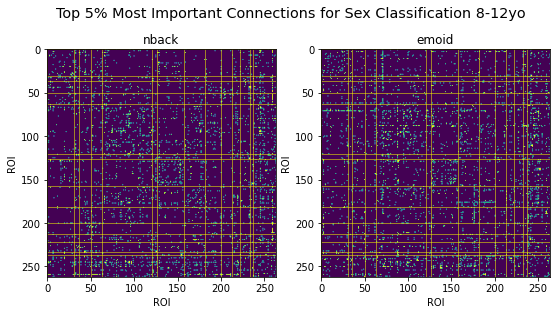

In [248]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def maskDiag(A):
    if A.ndim != 2 or A.shape[0] != A.shape[1]:
        raise Exception('bad A shape')
    return A*(1-np.eye(A.shape[0]))

def rearrange(p,idcs):
    return p[:,idcs][idcs]

fig, ax = plt.subplots(1,2,figsize=(9,4.2))

fig.suptitle(f'Top {100-q}% Most Important Connections for Sex Classification 8-12yo', y=1.02, fontsize='x-large')

# divider = make_axes_locatable(ax[0])
# cax1 = divider.append_axes('right', size='5%', pad=0.1)

color = 'yellow'

im1 = ax[0].imshow(dualDict['nbackSex'][0])
for b in borders1:
    ax[0].plot([0,263],[b,b],color=color,linewidth=0.5)
    ax[0].plot([b,b],[0,263],color=color,linewidth=0.5)
ax[0].set_ylabel('ROI')
ax[0].set_xlabel('ROI')
ax[0].set_title('nback')
ax[0].set_xlim(0,263)
ax[0].set_ylim(262,0)

# divider = make_axes_locatable(ax[1])
# cax2 = divider.append_axes('right', size='5%', pad=0.1)

im2 = ax[1].imshow(dualDict['emoidSex'][0])
for b in borders1:
    ax[1].plot([0,263],[b,b],color=color,linewidth=0.5)
    ax[1].plot([b,b],[0,263],color=color,linewidth=0.5)
ax[1].set_ylabel('ROI')
ax[1].set_xlabel('ROI')
ax[1].set_title('emoid')
ax[1].set_xlim(0,263)
ax[1].set_ylim(262,0)

# fig.colorbar(im1, cax=cax1, orientation='vertical')
# fig.colorbar(im2, cax=cax2, orientation='vertical')

fig.show()

In [250]:
with open('../../Work/Explainer/Results/DualDict.pkl', 'wb') as f:
    pickle.dump(dualDict, f)
    
print('Complete')

Complete


In [256]:
nnAgeSex = np.zeros([5,5])

for i in range(5):
    for j in range(5):
        nnAgeSex[i,j] = np.sum(dualDict['nbackAge'][i]*dualDict['nbackSex'][j])
        
print(nnAgeSex)

eeAgeSex = np.zeros([5,5])

for i in range(5):
    for j in range(5):
        eeAgeSex[i,j] = np.sum(dualDict['emoidAge'][i]*dualDict['emoidSex'][j])
        
print(eeAgeSex)

neAge = np.zeros([5,5])

for i in range(5):
    for j in range(5):
        neAge[i,j] = np.sum(dualDict['nbackAge'][i]*dualDict['emoidAge'][j])
        
print(neAge)

neSex = np.zeros([5,5])

for i in range(5):
    for j in range(5):
        neSex[i,j] = np.sum(dualDict['nbackSex'][i]*dualDict['emoidSex'][j])
        
print(neSex)

[[270. 266. 206. 242. 180.]
 [305. 213. 187. 225. 179.]
 [281. 265. 123. 227. 189.]
 [242. 228. 182. 215. 177.]
 [244. 209. 180. 254. 173.]]
[[200. 193. 179. 199. 249.]
 [200. 164. 166. 186. 232.]
 [225. 183. 174. 176. 231.]
 [187. 155. 165. 165. 209.]
 [228. 195. 220. 176. 200.]]
[[1646. 1667. 1552. 1156. 1115.]
 [1590. 1861. 1629. 1197. 1142.]
 [1463. 1655. 1584. 1105. 1057.]
 [1194. 1273. 1191. 1096.  912.]
 [1031. 1111. 1020.  792. 1006.]]
[[408. 226. 202. 253. 200.]
 [247. 459. 251. 253. 220.]
 [216. 243. 593. 230. 236.]
 [231. 228. 230. 644. 269.]
 [191. 230. 244. 333. 520.]]


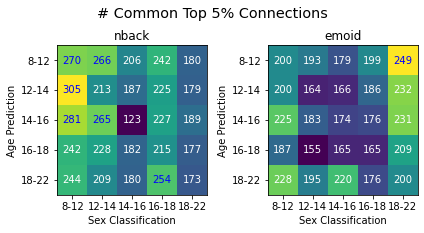

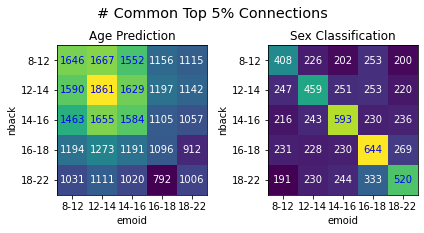

In [278]:

x = ["8-12", "12-14", "14-16", "16-18", "18-22"]
y = ["8-12", "12-14", "14-16", "16-18", "18-22"]

data = [nnAgeSex.astype(int), eeAgeSex.astype(int)]
label = ["nback", "emoid"]

fig, ax = plt.subplots(1,2)

for pIdx in range(2):
    im = ax[pIdx].imshow(data[pIdx])

    # Show all ticks and label them with the respective list entries
    ax[pIdx].set_xticks(np.arange(5), labels=x)
    ax[pIdx].set_yticks(np.arange(5), labels=y)
    ax[pIdx].set_ylabel("Age Prediction")
    ax[pIdx].set_xlabel("Sex Classification")

    # Rotate the tick labels and set their alignment.
    # plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    #          rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(5):
        for j in range(5):
            color = 'w'
            if data[pIdx][i,j] > 245:
                color = 'b'
            text = ax[pIdx].text(j, i, data[pIdx][i, j],
                           ha="center", va="center", color=color)

    ax[pIdx].set_title(f"{label[pIdx]}")
fig.suptitle("# Common Top 5% Connections", y=0.85, fontsize='x-large')
fig.tight_layout()
plt.show()

data = [neAge.astype(int), neSex.astype(int)]
label = ["Age Prediction", "Sex Classification"]

fig, ax = plt.subplots(1,2)

for pIdx in range(2):
    im = ax[pIdx].imshow(data[pIdx])

    # Show all ticks and label them with the respective list entries
    ax[pIdx].set_xticks(np.arange(5), labels=x)
    ax[pIdx].set_yticks(np.arange(5), labels=y)
    ax[pIdx].set_ylabel("nback")
    ax[pIdx].set_xlabel("emoid")

    # Rotate the tick labels and set their alignment.
    # plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    #          rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(5):
        for j in range(5):
            color = 'w'
            if data[pIdx][i,j] > 1300 and pIdx == 0 or data[pIdx][i,j] > 500 and pIdx == 1:
                color = 'b'
            text = ax[pIdx].text(j, i, data[pIdx][i, j],
                           ha="center", va="center", color=color)

    ax[pIdx].set_title(f"{label[pIdx]}")
fig.suptitle("# Common Top 5% Connections", y=0.85, fontsize='x-large')
fig.tight_layout()
plt.show()

/tmp/ipykernel_87765/3963612123.py:74: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


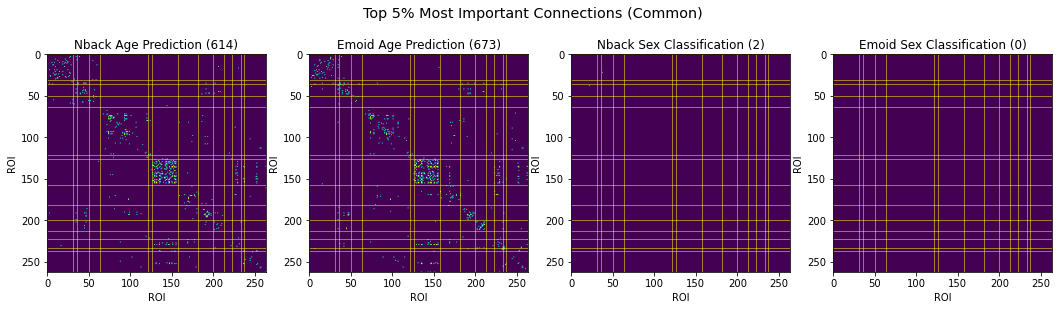

In [284]:
comNA = np.ones([264,264])
comNS = np.ones([264,264])
comEA = np.ones([264,264])
comES = np.ones([264,264])

for i in range(5):
    comNA *= dualDict['nbackAge'][i]
    comNS *= dualDict['nbackSex'][i]
    comEA *= dualDict['emoidAge'][i]
    comES *= dualDict['emoidSex'][i]
    
fig, ax = plt.subplots(1,4,figsize=(18,4.2))

fig.suptitle(f'Top {100-q}% Most Important Connections (Common)', y=1.02, fontsize='x-large')

# divider = make_axes_locatable(ax[0])
# cax1 = divider.append_axes('right', size='5%', pad=0.1)

color = 'yellow'

im1 = ax[0].imshow(comNA)
for b in borders1:
    ax[0].plot([0,263],[b,b],color=color,linewidth=0.5)
    ax[0].plot([b,b],[0,263],color=color,linewidth=0.5)
ax[0].set_ylabel('ROI')
ax[0].set_xlabel('ROI')
ax[0].set_title('nback')
ax[0].set_xlim(0,263)
ax[0].set_ylim(262,0)
ax[0].set_title(f'Nback Age Prediction ({int(np.sum(comNA))})')

# divider = make_axes_locatable(ax[1])
# cax2 = divider.append_axes('right', size='5%', pad=0.1)

im2 = ax[1].imshow(comEA)
for b in borders1:
    ax[1].plot([0,263],[b,b],color=color,linewidth=0.5)
    ax[1].plot([b,b],[0,263],color=color,linewidth=0.5)
ax[1].set_ylabel('ROI')
ax[1].set_xlabel('ROI')
ax[1].set_title('emoid')
ax[1].set_xlim(0,263)
ax[1].set_ylim(262,0)
ax[1].set_title(f'Emoid Age Prediction ({int(np.sum(comEA))})')

im1 = ax[2].imshow(comNS)
for b in borders1:
    ax[2].plot([0,263],[b,b],color=color,linewidth=0.5)
    ax[2].plot([b,b],[0,263],color=color,linewidth=0.5)
ax[2].set_ylabel('ROI')
ax[2].set_xlabel('ROI')
ax[2].set_title('nback')
ax[2].set_xlim(0,263)
ax[2].set_ylim(262,0)
ax[2].set_title(f'Nback Sex Classification ({int(np.sum(comNS))})')

# divider = make_axes_locatable(ax[1])
# cax2 = divider.append_axes('right', size='5%', pad=0.1)

im2 = ax[3].imshow(comES)
for b in borders1:
    ax[3].plot([0,263],[b,b],color=color,linewidth=0.5)
    ax[3].plot([b,b],[0,263],color=color,linewidth=0.5)
ax[3].set_ylabel('ROI')
ax[3].set_xlabel('ROI')
ax[3].set_title('emoid')
ax[3].set_xlim(0,263)
ax[3].set_ylim(262,0)
ax[3].set_title(f'Emoid Sex Classification ({int(np.sum(comES))})')

# fig.colorbar(im1, cax=cax1, orientation='vertical')
# fig.colorbar(im2, cax=cax2, orientation='vertical')

fig.show()

In [317]:
def getTopSystems(binfc, n):
    L = int(15*14/2)
    keys = np.zeros([L,2])
    vals = np.zeros(L)
    idx = 0
    for i in range(14):
        i0 = borders1[i]
        i1 = borders1[i+1]
        for j in range(i,14):
            j0 = borders1[j]
            j1 = borders1[j+1]
            s = np.sum(binfc[i0:i1,j0:j1])
            keys[idx][0] = i
            keys[idx][1] = j
            vals[idx] = s
            idx += 1
    idcs = np.argsort(vals)
    return keys[idcs][::-1,:][0:n,:], vals[idcs][::-1][0:n]

def prettyPrintSystems(sysRes, title):
    lookup = ["SM Hand", "SM Mouth", "CNG", "AUD", "DMN", "MEM", "VIS", "FRNT", "SAL", "SUB", "VTRL", "DRSL", "CB", "UNK"]
    keys = sysRes[0].astype(int)
    vals = sysRes[1].astype(int)
    print(title)
    for i in range(keys.shape[0]):
        print(f'{lookup[keys[i,0]]}-{lookup[keys[i,1]]} {vals[i]}')

ageLabels = ["8-12", "12-14", "14-16", "16-18", "18-22"]

for i in range(5):
    prettyPrintSystems(getTopSystems(dualDict['nbackAge'][i], 5), f"nback Age Prediction {ageLabels[i]}")
    
for i in range(5):
    prettyPrintSystems(getTopSystems(dualDict['emoidAge'][i], 5), f"emoid Age Prediction {ageLabels[i]}")

for i in range(5):
    prettyPrintSystems(getTopSystems(dualDict['nbackSex'][i], 5), f"nback Sex Classification {ageLabels[i]}")
    
for i in range(5):
    prettyPrintSystems(getTopSystems(dualDict['emoidSex'][i], 5), f"emoid Sex Classification {ageLabels[i]}")

nback Age Prediction 8-12
DMN-DMN 506
VIS-VIS 407
SM Hand-SM Hand 172
FRNT-FRNT 131
DMN-FRNT 79
nback Age Prediction 12-14
DMN-DMN 518
VIS-VIS 377
SM Hand-SM Hand 220
FRNT-FRNT 123
DMN-FRNT 86
nback Age Prediction 14-16
DMN-DMN 476
VIS-VIS 350
SM Hand-SM Hand 213
FRNT-FRNT 123
DMN-UNK 85
nback Age Prediction 16-18
DMN-DMN 407
VIS-VIS 372
SM Hand-SM Hand 179
DMN-VIS 74
DMN-FRNT 72
nback Age Prediction 18-22
DMN-DMN 414
VIS-VIS 278
SM Hand-SM Hand 159
FRNT-FRNT 98
DMN-UNK 76
emoid Age Prediction 8-12
VIS-VIS 433
DMN-DMN 424
SM Hand-SM Hand 162
VIS-DRSL 85
VIS-UNK 78
emoid Age Prediction 12-14
DMN-DMN 490
VIS-VIS 420
SM Hand-SM Hand 205
FRNT-FRNT 79
VIS-UNK 69
emoid Age Prediction 14-16
DMN-DMN 447
VIS-VIS 390
SM Hand-SM Hand 184
VIS-DRSL 76
DMN-FRNT 65
emoid Age Prediction 16-18
DMN-DMN 317
VIS-VIS 272
SM Hand-SM Hand 180
DMN-FRNT 67
SM Hand-DMN 60
emoid Age Prediction 18-22
DMN-DMN 407
VIS-VIS 358
SM Hand-SM Hand 88
DMN-UNK 78
DMN-FRNT 77
nback Sex Classification 8-12
DMN-DMN 271
DMN-UN